In [1]:
from model.utils import timestep_embedding, timesteps_to_tensor
import torch.nn.functional as F

from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging
from typing import Tuple
import math

# from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily, MultivariateNormal
import torch

# device = torch.device('mps') # device = 'mps:0'
# device = 'cuda:0'
device = 'cpu'

import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure




In [2]:
class ResNet_FC(nn.Module):
  def __init__(self, data_dim, hidden_dim, num_res_blocks):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.map=nn.Linear(data_dim, hidden_dim)
    self.res_blocks = nn.ModuleList(
        [self.build_res_block() for _ in range(num_res_blocks)])

  def build_linear(self, in_features, out_features):
    linear = nn.Linear(in_features, out_features)
    return linear

  def build_res_block(self):
    hid = self.hidden_dim
    layers = []
    widths =[hid]*4  # [256, 256, 256, 256]
    for i in range(len(widths) - 1):
      layers.append(self.build_linear(widths[i], widths[i + 1]))
      layers.append(nn.SiLU())
    return nn.Sequential(*layers) # [batch_size, dim]

  def forward(self, x):  # x_t: [batch_size, data_dim]
    h=self.map(x)
    for res_block in self.res_blocks:
      h = (h + res_block(h)) / np.sqrt(2)
    return h   # [batch_size, dim]



In [3]:
class ToyNet(nn.Module):
    def __init__(self, data_dim, direction=None):
        super(ToyNet, self).__init__()
        self.direction = direction

        self.time_embed_dim = 128
        dim = 256
        out_dim = data_dim

        self.t_module = nn.Sequential(nn.Linear(self.time_embed_dim, dim), nn.SiLU(), nn.Linear(dim, dim),)
        self.x_module = ResNet_FC(data_dim, dim, num_res_blocks=1)
        self.out_module = nn.Sequential(nn.Linear(dim,dim), nn.SiLU(), nn.Linear(dim, out_dim),)

    def forward(self, x, t: int or list[int]): # x_t: [batch_size, data_dim]
        t = timesteps_to_tensor(t, batch_size=x.shape[0]).to(x.device)
        t_emb = timestep_embedding(t, self.time_embed_dim)  # [batch_size, time_embed_dim]

        t_out = self.t_module(t_emb) # [batch_size, dim=256]
        x_out = self.x_module(x) # [batch_size, dim=256]
        out   = self.out_module(x_out+t_out) # [batch_size, out_dim=data_dim]

        return out



In [4]:
class FFN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int]):
      super().__init__()
      blocks = []
      input_dim_block = input_dim

      for hidden_dim in hidden_dims:
          blocks.append(nn.Linear(input_dim_block, hidden_dim))
          blocks.append(nn.SiLU())
          input_dim_block = hidden_dim
      blocks.append(nn.Linear(input_dim_block, output_dim))
      self.network = nn.Sequential(*blocks)
      self.output_dim = output_dim

    def forward(self, x):
      out = self.network(x)
      return out




In [22]:
def get_coarse_noise_trajs(traj_noise,traj_drift,ratio,dt):
  '''
  Arguments:
    traj_noise (torch.Tensor): N,total_steps,input_dim
    traj_drift (torch.Tensor): N, total_steps,input_dim
    ratio (int): num of fine steps per coarse step
    dt (float): the fine time step size

  Returns:
    coarse_noise_trajs (torch.Tensor): N, total_csteps, 2*input_dim
  '''
  N,total_steps,input_dim = traj_noise.shape
  total_csteps = math.ceil(total_steps/ratio)
  coarse_noise_trajs = torch.zeros(N,total_csteps,2*input_dim)
  for cstep in range(total_csteps):
    start_ind = cstep*ratio
    end_ind = min((cstep+1)*ratio, total_steps)
    BM_coarse = torch.sum(traj_drift[:,start_ind:end_ind]*traj_noise[:,start_ind:end_ind], dim=1) / traj_drift[:,start_ind]

    time_steps = torch.arange(start_ind*dt,end_ind*dt, dtype=torch.float32)
    time_increments = torch.diff(time_steps)
    BM_coarse_integral = torch.sum(time_increments.unsqueeze(0).unsqueeze(1)
                        *traj_noise[:,start_ind:end_ind], dim=1) # N,input_dim
    coarse_noise_trajs[:,cstep,:] = torch.cat((BM_coarse,BM_coarse_integral),dim=1)
  return coarse_noise_trajs




In [6]:
class BaseGenerator(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim=1):
    super(BaseGenerator, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

  def sample_eps(self, batch_size, input_dim, c_dt):
    """
    Generate i.i.d. Gaussian random variables with a defined covariance matrix.
    """
    cov_matrix = torch.tensor([[c_dt, (c_dt**2/2)],
                                [(c_dt**2/2), (c_dt**3/3)]])
    m = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=cov_matrix)
    eps = m.sample((batch_size, input_dim))  # [N, input_dim, 2]
    return torch.reshape(eps, (batch_size, input_dim * 2))  # [N, 2*input_dim]

  def forward(self, *args, **kwargs):
    raise NotImplementedError("Forward pass should be implemented in derived class.")




In [7]:
def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.kaiming_normal_(m.weight, a=1.3, mode='fan_in', nonlinearity='leaky_relu')
    try:
      nn.init.zeros_(m.bias)
      # nn.init.normal_(m.bias, mean=0., std=0.01)
    except:
      pass


    

In [8]:
class FNNGenerator(BaseGenerator):
  def __init__(self, input_dim, hidden_dim, output_dim=1):
    super(FNNGenerator, self).__init__(input_dim, hidden_dim, output_dim)
    self.ffn = FFN(input_dim=2+3*input_dim, output_dim=output_dim, hidden_dims=[hidden_dim, hidden_dim])
    self.ffn.apply(init_weights)

  def forward(self, x_t, noise_trajs, starting_point, c_dt):
    '''
    noise_trajs (torch.Tensor)
    '''
    cdt_tensor = torch.tensor([c_dt]).unsqueeze(0).repeat(x_t.shape[0], 1).to(device)  # [N,1]
    t_tensor = torch.tensor([starting_point]).unsqueeze(0).repeat(x_t.shape[0], 1).to(device)  # [N,1]
    out = x_t + self.ffn(torch.cat((t_tensor, x_t, cdt_tensor, noise_trajs), dim=1)) # [N, input_dim]
    return out  # [N, output_dim=1]



In [9]:
# original diffusion process but with noise of backward process being recorded
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}},
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)

    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation:
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t # [N]


    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device) # [N,d=1]
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        noise = z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return f_t, g_t, noise, x_prev # [N,d=1]

    # record the noise
    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise # [N,1]
        trajs = [x_t]
        noise_trajs = []
        drift_trajs = []
        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            f_t, g_t, noise, x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
            noise_trajs.append(noise)
            if isinstance(g_t, np.float64):
              g_t = torch.tensor(g_t,dtype=torch.float32).unsqueeze(0)
            drift_trajs.append(g_t)
        return x_t, torch.hstack(drift_trajs), torch.hstack(noise_trajs), torch.hstack(trajs)

    def forward_sample(self, data): # data: torch.tensor, shape=[N]
        trajs = torch.zeros([len(data), self.total_steps+1]) # [N, T+1]
        x = data.to(device) # [N]
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t) # [N]
            trajs[:, t] = x
        return x, trajs # [N], [N,T+1]

    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise # [N,d=1]
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            f_t, g_t, noise, x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs) # [N,d=1], [N,(T+1)*d]

    def backward_sample_example(self, noise, net):
        """
        Sample from backward diffusion process
        noise: torch.tensor, shape=[num_paths, T]
        """
        noise_end = noise[:, -1]
        trajs = torch.zeros_like(noise)
        trajs[:, -1] = noise_end
        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(noise[:,t].unsqueeze(1), t) # [N,d=1]
            noise, x_t = self.backward_one_step(noise[:,t].unsqueeze(1), t, pred_score)
            trajs[:,t-1] = x_t.squeeze()
        return x_t, trajs




In [10]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)



In [23]:
total_steps = 100
ratio = 4
score_net = ToyNet(data_dim=1).to(device)
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

num_epochs = 100
batch_size = 64
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

def loss_function(x0, diffusion_process, score_net, t):
  _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
  mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
  z = torch.randn_like(x0)
  x_t = mean + std * z  # x_t is perturbed x_0
  pred_score = score_net(x_t, t)
  target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
  loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
  return loss

# training the original diffusion model
score_net.train()
for i in range(num_epochs):
  opt.zero_grad()
  x0 = data_dist.sample([batch_size]).to(device)
  t = np.random.randint(1, total_steps + 1)
  loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
  loss.backward()
  opt.step()

  


In [26]:
num_epochs = 300
batch_size = 64
total_coarse_steps = math.ceil(total_steps/ratio)
c_dt = diffusion.dt * ratio
generator = FNNGenerator(input_dim=1, hidden_dim=256, output_dim=1).to(device)
opt_supervised = torch.optim.Adam(generator.parameters(), lr=5e-4)
criterion = nn.MSELoss()

# training the original diffusion model
generator.train()
for epoch in range(num_epochs):
  x_gen, traj_drift, traj_noise, traj_back = diffusion.sample(torch.randn([batch_size, 1]).to(device), score_net)  # generate backward process using trained diffusion model
  coarse_noise_trajs = get_coarse_noise_trajs(traj_noise.view(-1,total_steps,1),
                                              traj_drift.view(-1,total_steps,1),
                                              ratio,
                                              diffusion.dt)
  # print('coarse_noise_trajs shape:',coarse_noise_trajs.shape) # N,csteps,2*input_dim
  coarse_traj_back = traj_back[:,::ratio]
  tstart_index = diffusion.total_steps
  starting_time = diffusion.dt*tstart_index
  x_t = torch.randn([batch_size,1])
  pred_traj_back = [x_t]
  for t in range(total_coarse_steps):
    x_t = generator(x_t, coarse_noise_trajs[:,t,:], starting_time, c_dt)
    pred_traj_back.append(x_t)
  pred_traj_back = torch.hstack(pred_traj_back)
  loss = criterion(pred_traj_back, coarse_traj_back)
  opt_supervised.zero_grad()
  loss.backward()
  opt_supervised.step()
  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/300], Loss: 1.8374
Epoch [20/300], Loss: 1.5272
Epoch [30/300], Loss: 1.3853
Epoch [40/300], Loss: 1.3769
Epoch [50/300], Loss: 1.3853
Epoch [60/300], Loss: 1.4593
Epoch [70/300], Loss: 1.3189
Epoch [80/300], Loss: 1.4427
Epoch [90/300], Loss: 1.6878
Epoch [100/300], Loss: 1.4272
Epoch [110/300], Loss: 1.4512
Epoch [120/300], Loss: 1.5014
Epoch [130/300], Loss: 1.3966
Epoch [140/300], Loss: 1.5180
Epoch [150/300], Loss: 1.3607
Epoch [160/300], Loss: 1.3574
Epoch [170/300], Loss: 1.2995
Epoch [180/300], Loss: 1.3837
Epoch [190/300], Loss: 1.2896
Epoch [200/300], Loss: 1.1093
Epoch [210/300], Loss: 1.1793
Epoch [220/300], Loss: 1.3160
Epoch [230/300], Loss: 1.2188
Epoch [240/300], Loss: 1.1965
Epoch [250/300], Loss: 1.1282
Epoch [260/300], Loss: 0.9652
Epoch [270/300], Loss: 0.8821
Epoch [280/300], Loss: 0.6131
Epoch [290/300], Loss: 0.5566
Epoch [300/300], Loss: 0.4541


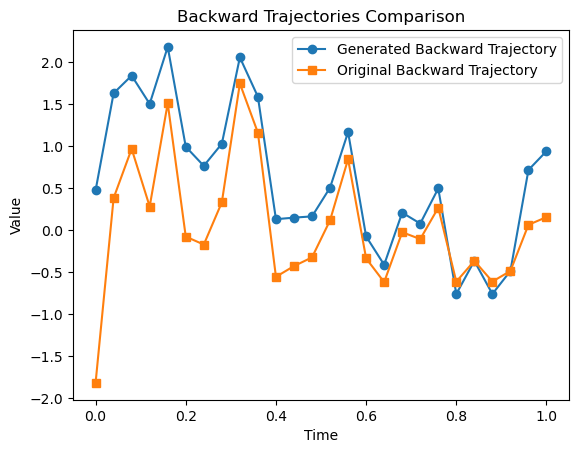

In [29]:
sample_index = 0
x_gen, traj_drift, traj_noise, traj_back = diffusion.sample(torch.randn([batch_size, 1]).to(device), score_net)
coarse_noise_trajs = get_coarse_noise_trajs(traj_noise.view(-1, total_steps, 1),
                                            traj_drift.view(-1, total_steps, 1),
                                            ratio,
                                            diffusion.dt)
coarse_traj_back = traj_back[:, ::ratio]
tstart_index = diffusion.total_steps
starting_time = diffusion.dt * tstart_index
x_t = torch.randn([1, 1]) 
pred_traj_back = [x_t]
with torch.no_grad():
    for t in range(total_coarse_steps):
        x_t = generator(x_t, coarse_noise_trajs[sample_index: sample_index + 1, t, :], starting_time, c_dt)
        pred_traj_back.append(x_t)
pred_traj_back = torch.hstack(pred_traj_back).squeeze().cpu().detach().numpy()


original_traj_back = coarse_traj_back[sample_index].cpu().detach().numpy()

time_steps = [i * c_dt for i in range(total_coarse_steps + 1)]
plt.plot(time_steps, pred_traj_back, label='Generated Backward Trajectory', marker='o')
plt.plot(time_steps, original_traj_back, label='Original Backward Trajectory', marker='s')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Backward Trajectories Comparison')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# plot score-based backward diffusion process and sigRNN predicted backward process in one plot for comparision


# backward process
generator.eval()
with torch.no_grad():
  x_t = x_0
  starting_time = diffusion.dt*tstart_index
  traj_back = [x_t]
  for t in range(total_coarse_steps):
    x_t = generator(x_t, noise_trajs[:,-t-1].unsqueeze(1), starting_time, diffusion.c_dt)
    traj_back.append(x_t)
  predicted_x_T = traj_back[-1]
  traj_back = torch.hstack(traj_back)

  plt.figure(figsize=(12,3))
  plt.subplot(1, 2, 1)
  time_t = np.linspace(0, 1, traj_forward.shape[1])
  for line in traj_forward:
    plt.plot(time_t, line.cpu(), linewidth=1.0)
    plt.title('forward')
  plt.ylim(-5, 5)

  plt.subplot(1, 2, 2)
  time_c = np.linspace(0, 1, traj_back.shape[1])
  for line in traj_back:
    plt.plot(time_c, line.cpu(), linewidth=1.0)
    plt.title('backward')
  plt.ylim(-5, 5)
  plt.show()

  


